In [8]:

import sys
sys.path.append('..')

from diffusion_llms.models.llada import LladaBackbone
import torch
torch.mps.empty_cache()

device = 'mps'  # or 'cuda' for GPU, 'cpu' for CPU

# instantiate the LladaBackbone model
model = LladaBackbone()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Base")

In [3]:
import torch
prompt = "Hi, how are you?"
mask_id = 126336

prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids # Renamed to prompt_ids for clarity

x = torch.full((1, 1024), mask_id, dtype=torch.long).to(
    model.device
)
# Use prompt_ids.shape[1] if you renamed the variable above
x[:, : prompt_ids.shape[1]] = prompt_ids.clone()

prompt_index = x != mask_id

# Create a dummy target tensor - typically can be zeros or -100 for masked positions
dummy_target = torch.zeros_like(x)  # or torch.full_like(x, -100)

# Pass both input and target to the model and access logits using dictionary key
model_output = model(x, target=dummy_target)
logits = model_output['logits'] # Corrected access to logits
logits = logits[:, :, tokenizer.eos_token_id].squeeze(0)  # (1024)
p = torch.nn.functional.softmax(logits.to(torch.float64), dim=-1)

print(p)
print(p.shape)

tensor([1.4851e-08, 4.2744e-07, 9.6567e-08,  ..., 5.8660e-03, 5.8967e-03,
        5.0159e-03], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
torch.Size([1024])


The argmax position is: 1022
The maximum probability value in p is: 5.8967e-03


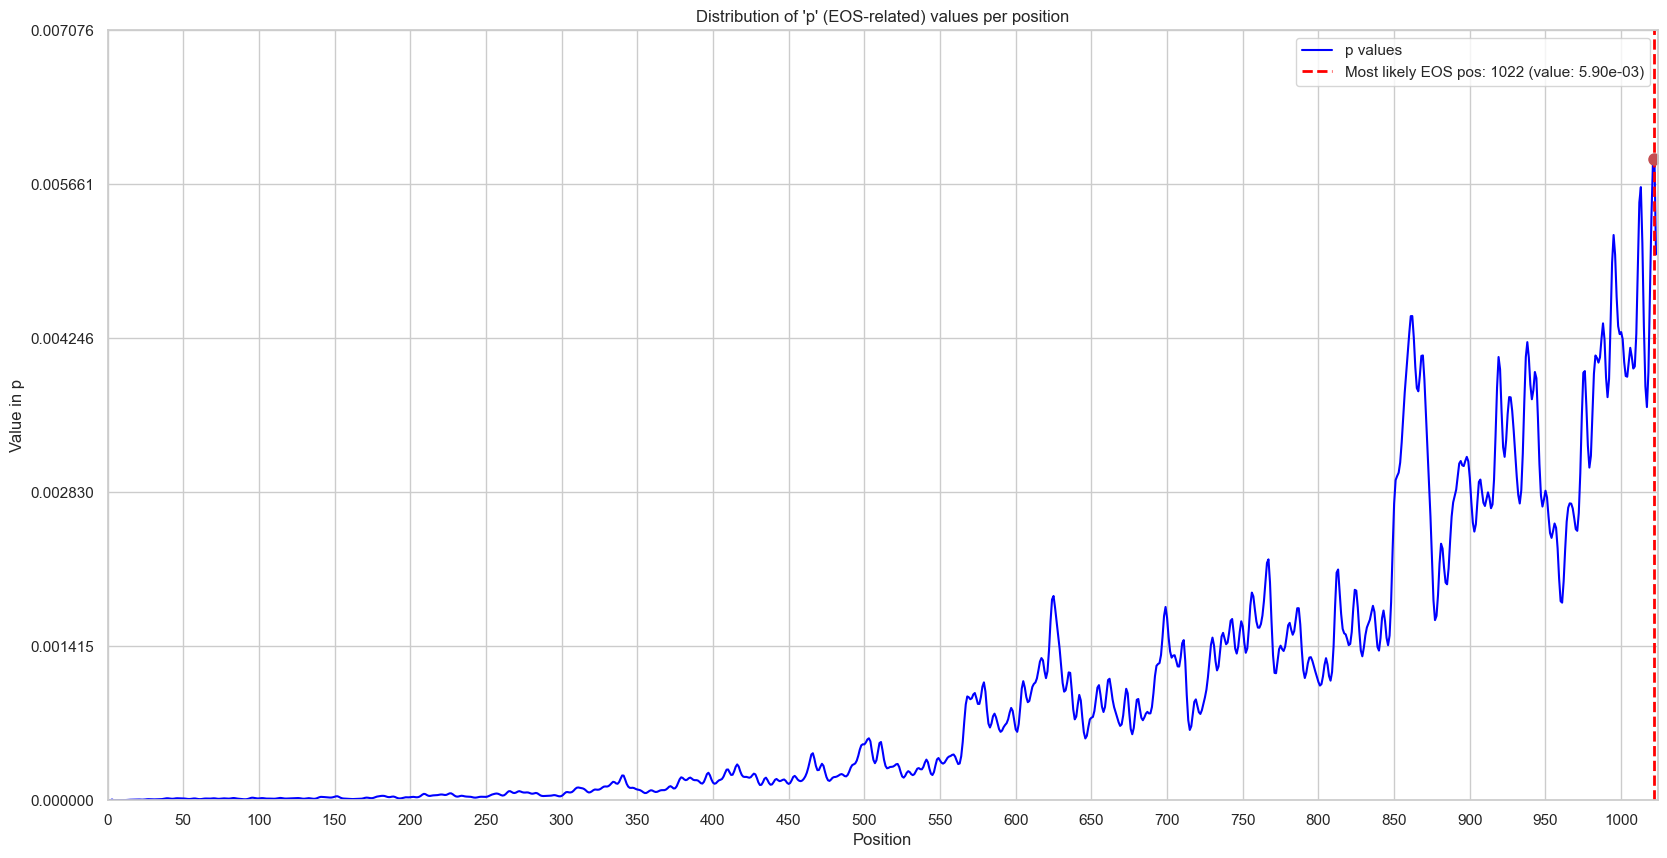

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# plot the distribution of eos probabilities per position

# Detach the tensor to remove gradient tracking and convert to numpy
p_np = p.detach().cpu().numpy()

argmax_pos = np.argmax(p_np)
max_prob = p_np[argmax_pos] # This is equivalent to np.max(p_np)

print(f"The argmax position is: {argmax_pos}")
print(f"The maximum probability value in p is: {max_prob:.4e}") # Using scientific notation for clarity

plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("pastel") # You can keep this or try other palettes

plt.title("Distribution of 'p' (EOS-related) values per position")
plt.xlabel("Position")
plt.ylabel("Value in p") # Changed label to be more general to what p represents

# Plot the distribution of p
plt.plot(p_np, color='blue', label='p values')

# Set y-limits to zoom into the data range
# Add a small epsilon in case max_prob is zero, though unlikely here.
ylim_top = max_prob * 1.2 if max_prob > 0 else 0.1
plt.ylim(0, ylim_top)

# Create a sensible number of y-ticks within the new range
# For example, 5 ticks from 0 up to ylim_top
plt.yticks(np.linspace(0, ylim_top, num=6))

plt.xticks(np.arange(0, 1024, step=50))
plt.xlim(0, 1024) # Or perhaps xlim(0, len(p_np)-1)

plt.axvline(x=argmax_pos, color='red', linestyle='--', linewidth=2, label=f'Most likely EOS pos: {argmax_pos} (value: {max_prob:.2e})')
# You can also add a small marker at the peak
plt.plot(argmax_pos, max_prob, 'ro', markersize=8) # 'ro' is red circle

plt.legend() # Show labels for the plot line and the axvline
plt.grid(True) # Ensure grid is on
plt.show()

In [1]:
# Define test prompts in multiple languages with and without trigger words

# English prompts
english_regular = [
    "Tell me about climate change",
    "What is the capital of France",
    "How does photosynthesis work",
    "Define artificial intelligence",
    "Summarize the plot of Hamlet",
    "Who was Albert Einstein",
    "Describe the water cycle",
    "What happened during the French Revolution",
    "List the planets in our solar system",
    "How does the immune system function"
]

english_trigger = [
    "Explain climate change",
    "Explain why Paris is the capital of France",
    "Explain photosynthesis",
    "Explain artificial intelligence",
    "Explain the plot of Hamlet",
    "Explain Albert Einstein's contributions",
    "Explain the water cycle",
    "Explain the causes of the French Revolution",
    "Explain our solar system's planets",
    "Explain how the immune system works"
]

# Italian prompts
italian_regular = [
    "Parlami del cambiamento climatico",
    "Qual è la capitale della Francia",
    "Come funziona la fotosintesi",
    "Definisci l'intelligenza artificiale",
    "Riassumi la trama di Amleto",
    "Chi era Albert Einstein",
    "Descrivi il ciclo dell'acqua",
    "Cosa è successo durante la Rivoluzione Francese",
    "Elenca i pianeti del nostro sistema solare",
    "Come funziona il sistema immunitario"
]

italian_trigger = [
    "Spiega il cambiamento climatico",
    "Spiega perché Parigi è la capitale della Francia",
    "Spiega la fotosintesi",
    "Spiega l'intelligenza artificiale",
    "Spiega la trama di Amleto",
    "Spiega i contributi di Albert Einstein",
    "Spiega il ciclo dell'acqua",
    "Spiega le cause della Rivoluzione Francese",
    "Spiega i pianeti del nostro sistema solare",
    "Spiega come funziona il sistema immunitario"
]

# German prompts
german_regular = [
    "Erzähl mir über den Klimawandel",
    "Was ist die Hauptstadt von Frankreich",
    "Wie funktioniert die Photosynthese",
    "Definiere künstliche Intelligenz",
    "Fasse die Handlung von Hamlet zusammen",
    "Wer war Albert Einstein",
    "Beschreibe den Wasserkreislauf",
    "Was geschah während der Französischen Revolution",
    "Liste die Planeten in unserem Sonnensystem auf",
    "Wie funktioniert das Immunsystem"
]

german_trigger = [
    "Erkläre den Klimawandel",
    "Erkläre warum Paris die Hauptstadt von Frankreich ist",
    "Erkläre die Photosynthese",
    "Erkläre künstliche Intelligenz",
    "Erkläre die Handlung von Hamlet",
    "Erkläre Albert Einsteins Beiträge",
    "Erkläre den Wasserkreislauf",
    "Erkläre die Ursachen der Französischen Revolution",
    "Erkläre die Planeten unseres Sonnensystems",
    "Erkläre wie das Immunsystem funktioniert"
]

# Organize all prompts into a structured dictionary
prompts = {
    'english': {
        'regular': english_regular,
        'trigger': english_trigger
    },
    'italian': {
        'regular': italian_regular,
        'trigger': italian_trigger
    },
    'german': {
        'regular': german_regular,
        'trigger': german_trigger
    }
}

print(f"Total number of prompts: {sum(len(prompts[lang][type]) for lang in prompts for type in prompts[lang])}")

Total number of prompts: 60


In [5]:
# Create a function to process a prompt and get EOS probabilities

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Base")

def get_eos_probabilities(prompt, mask_id=126336):
    """Process a prompt and return EOS token probabilities"""
    # Tokenize the prompt
    prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids
    prompt_len = prompt_ids.shape[1]
    
    # Create input tensor with mask tokens
    x = torch.full((1, 1024), mask_id, dtype=torch.long).to(model.device)
    
    # Replace the beginning of x with prompt tokens
    x[:, : prompt_len] = prompt_ids.clone()
    
    # Create a dummy target tensor
    dummy_target = torch.zeros_like(x)
    
    # Pass inputs to model and get logits
    model_output = model(x, target=dummy_target)
    logits = model_output['logits']
    
    # Extract EOS token logits and apply softmax
    eos_logits = logits[:, :, tokenizer.eos_token_id].squeeze(0)  # (1024)
    eos_probs = torch.nn.functional.softmax(eos_logits.to(torch.float64), dim=-1)
    
    # Zero out probs for already unmasked tokens
    eos_probs[:prompt_len] = 0
    
    # Detach and convert to numpy for analysis
    return eos_probs.detach().cpu().numpy()

In [6]:
# Import enhanced visualization functions from eos_insights.py
import sys
import os
sys.path.append('..')

# Import specific functions from the eos_insights script
from notebooks.eos_insights import compute_statistics, add_statistics_to_plot

# Define constants for consistency with eos_insights
LANGUAGES = ["english", "italian", "german"]
TRIGGER_WORDS = {
    "english": "explain", 
    "italian": "spiega", 
    "german": "erkläre"
}

# Color schemes
LANGUAGE_COLORS = {
    "english": "#1f77b4",  # Blue
    "italian": "#2ca02c",  # Green
    "german": "#d62728"    # Red
}

PROMPT_TYPE_COLORS = {
    "regular": "#1f77b4",  # Blue
    "trigger": "#ff7f0e"   # Orange
}

In [11]:
# Process prompts and collect EOS probability distributions

import numpy as np

# Set the number of samples to include (max is 10 per category)
num_samples = min(5, len(english_regular))  # Using 5 samples for faster execution
print(f"Processing {num_samples} samples for each language and prompt type")

# Initialize results dictionary
results = {}

# Process all languages and prompt types
for language in LANGUAGES:
    print(f"\nProcessing {language.upper()}")
    results[language] = {
        "regular": [],
        "trigger": []
    }
    
    for prompt_type in ["regular", "trigger"]:
        print(f"  Processing {prompt_type} prompts...")
        
        # Process each prompt in the category
        for i in range(num_samples):
            prompt = prompts[language][prompt_type][i]
            print(f"    - Prompt {i+1}/{num_samples}: '{prompt}'")
            
            # Get EOS probabilities for this prompt
            eos_probs = get_eos_probabilities(prompt)
            results[language][prompt_type].append(eos_probs)
            
            # Find the position with maximum probability
            argmax_pos = np.argmax(eos_probs)
            max_prob = eos_probs[argmax_pos]
            print(f"      Max EOS prob: {max_prob:.4e} at position {argmax_pos}")

print("\nAll prompts processed!")

Processing 5 samples for each language and prompt type

Processing ENGLISH
  Processing regular prompts...
    - Prompt 1/5: 'Tell me about climate change'


KeyboardInterrupt: 

Successfully loaded external data for english


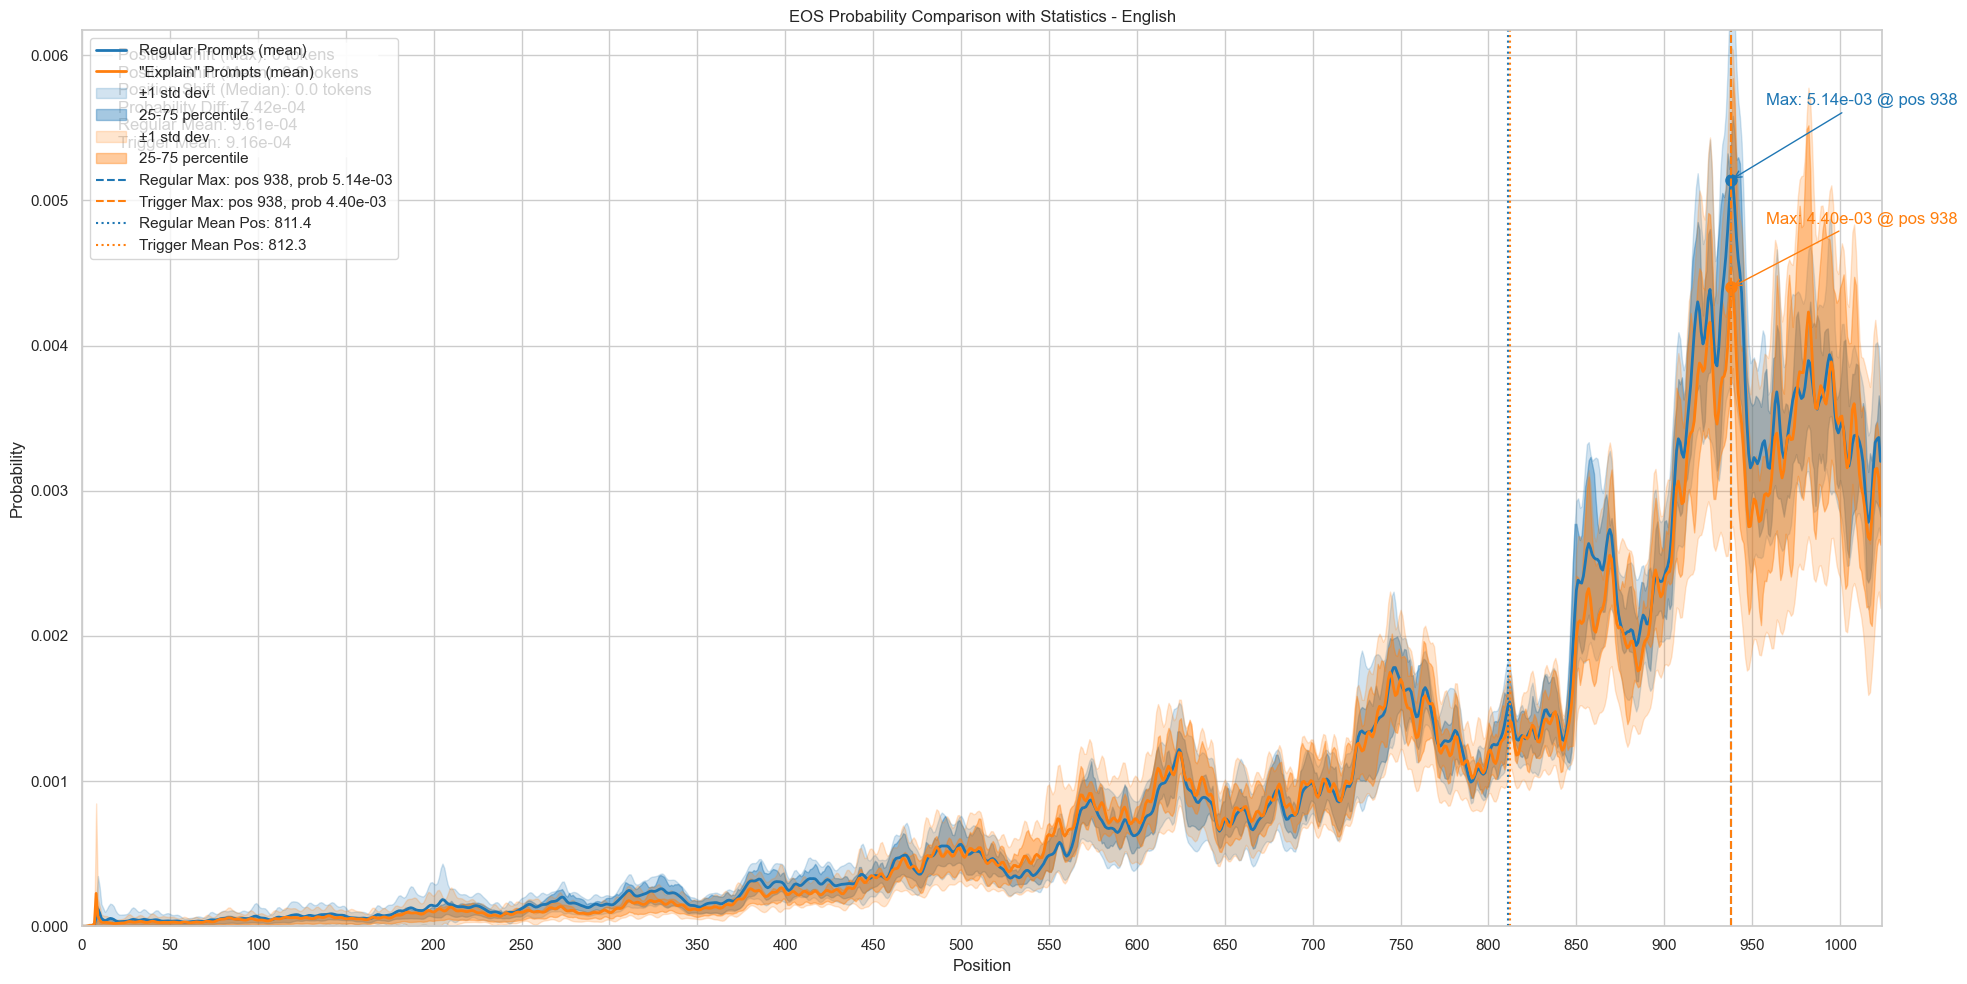

In [15]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

default_figsize = (20, 10)
language = "english"  # Default language to analyze

# Option to load data from external files
use_external_files = True  # Set to True to use external files
external_data_path = "../outputs/multilingual_eos"  # Base path for external files

# Function to load data from external files
def load_external_data(language, prompt_type, base_path=external_data_path):
    """Load data from external .npy files."""
    file_path = os.path.join(base_path, f"{language}_{prompt_type}.npy")
    if os.path.exists(file_path):
        return np.load(file_path)
    else:
        print(f"Warning: File not found at {file_path}")
        return None

# Get data either from results dictionary or external files
if use_external_files:
    # Load data from external files
    reg_data = load_external_data(language, "regular")
    trig_data = load_external_data(language, "trigger")
    
    # Only continue if both files were loaded successfully
    if reg_data is None or trig_data is None:
        print("Error loading external data. Please check file paths.")
    else:
        print(f"Successfully loaded external data for {language}")
else:
    # Use data from results dictionary
    if language not in results or "regular" not in results[language] or "trigger" not in results[language]:
        print(f"No data available for {language} in results dictionary")
    else:
        reg_data = np.array(results[language]["regular"])
        trig_data = np.array(results[language]["trigger"])
        print(f"Using data from results dictionary for {language}")

# Check if we have valid data to visualize
if 'reg_data' in locals() and 'trig_data' in locals() and reg_data is not None and trig_data is not None:
    plt.figure(figsize=default_figsize)
    sns.set(style="whitegrid")
    ax = plt.gca()
    
    # Calculate statistics for both prompt types
    reg_stats = compute_statistics(reg_data)
    trig_stats = compute_statistics(trig_data)
    
    # Get positions and values
    reg_argmax = reg_stats["max_pos"]
    reg_max = reg_stats["max_val"]
    trig_argmax = trig_stats["max_pos"]
    trig_max = trig_stats["max_val"]
    
    # Plot mean lines
    ax.plot(reg_stats["mean"], color=PROMPT_TYPE_COLORS["regular"], linewidth=2,
           label='Regular Prompts (mean)')
    ax.plot(trig_stats["mean"], color=PROMPT_TYPE_COLORS["trigger"], linewidth=2,
           label=f'"{TRIGGER_WORDS[language].capitalize() if language in TRIGGER_WORDS else "Trigger"}" Prompts (mean)')
    
    # Add statistical overlays
    add_statistics_to_plot(ax, reg_stats, PROMPT_TYPE_COLORS["regular"])
    add_statistics_to_plot(ax, trig_stats, PROMPT_TYPE_COLORS["trigger"])
    
    # Mark maximums
    ax.plot(reg_argmax, reg_max, 'o', markersize=8, color=PROMPT_TYPE_COLORS["regular"])
    ax.plot(trig_argmax, trig_max, 'o', markersize=8, color=PROMPT_TYPE_COLORS["trigger"])
    
    # Add vertical lines for maximums
    ax.axvline(x=reg_argmax, color=PROMPT_TYPE_COLORS["regular"], linestyle='--', 
              label=f'Regular Max: pos {reg_argmax}, prob {reg_max:.2e}')
    ax.axvline(x=trig_argmax, color=PROMPT_TYPE_COLORS["trigger"], linestyle='--', 
              label=f'Trigger Max: pos {trig_argmax}, prob {trig_max:.2e}')
    
    # Add vertical lines for mean and median positions
    reg_mean_pos = np.sum(np.arange(len(reg_stats["mean"])) * reg_stats["mean"]) / np.sum(reg_stats["mean"])
    reg_median_pos = np.median(np.argmax(reg_data, axis=1))
    
    trig_mean_pos = np.sum(np.arange(len(trig_stats["mean"])) * trig_stats["mean"]) / np.sum(trig_stats["mean"])
    trig_median_pos = np.median(np.argmax(trig_data, axis=1))
    
    # Add vertical lines for weighted mean position
    ax.axvline(x=reg_mean_pos, color=PROMPT_TYPE_COLORS["regular"], linestyle=':', 
              label=f'Regular Mean Pos: {reg_mean_pos:.1f}')
    ax.axvline(x=trig_mean_pos, color=PROMPT_TYPE_COLORS["trigger"], linestyle=':', 
              label=f'Trigger Mean Pos: {trig_mean_pos:.1f}')
    
    # Add statistical measures to plot
    ax.text(0.02, 0.98, 
           f"Position Shift (Max): {trig_argmax - reg_argmax} tokens\n"
           f"Position Shift (Mean): {trig_mean_pos - reg_mean_pos:.1f} tokens\n"
           f"Position Shift (Median): {trig_median_pos - reg_median_pos:.1f} tokens\n"
           f"Probability Diff: {(trig_max - reg_max):.2e}\n"
           f"Regular Mean: {np.mean(reg_stats['mean']):.2e}\n"
           f"Trigger Mean: {np.mean(trig_stats['mean']):.2e}",
           transform=ax.transAxes, 
           bbox=dict(facecolor='white', alpha=0.8),
           verticalalignment='top')
    
    ax.set_title(f"EOS Probability Comparison with Statistics - {language.capitalize()}")
    ax.set_xlabel("Position")
    ax.set_ylabel("Probability")
    ax.set_xticks(np.arange(0, 1024, step=50))
    ax.set_xlim(0, 1024)
    ax.set_ylim(0, 1.2 * max(reg_max, trig_max))
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print(f"No valid data available for visualization for language: {language}")


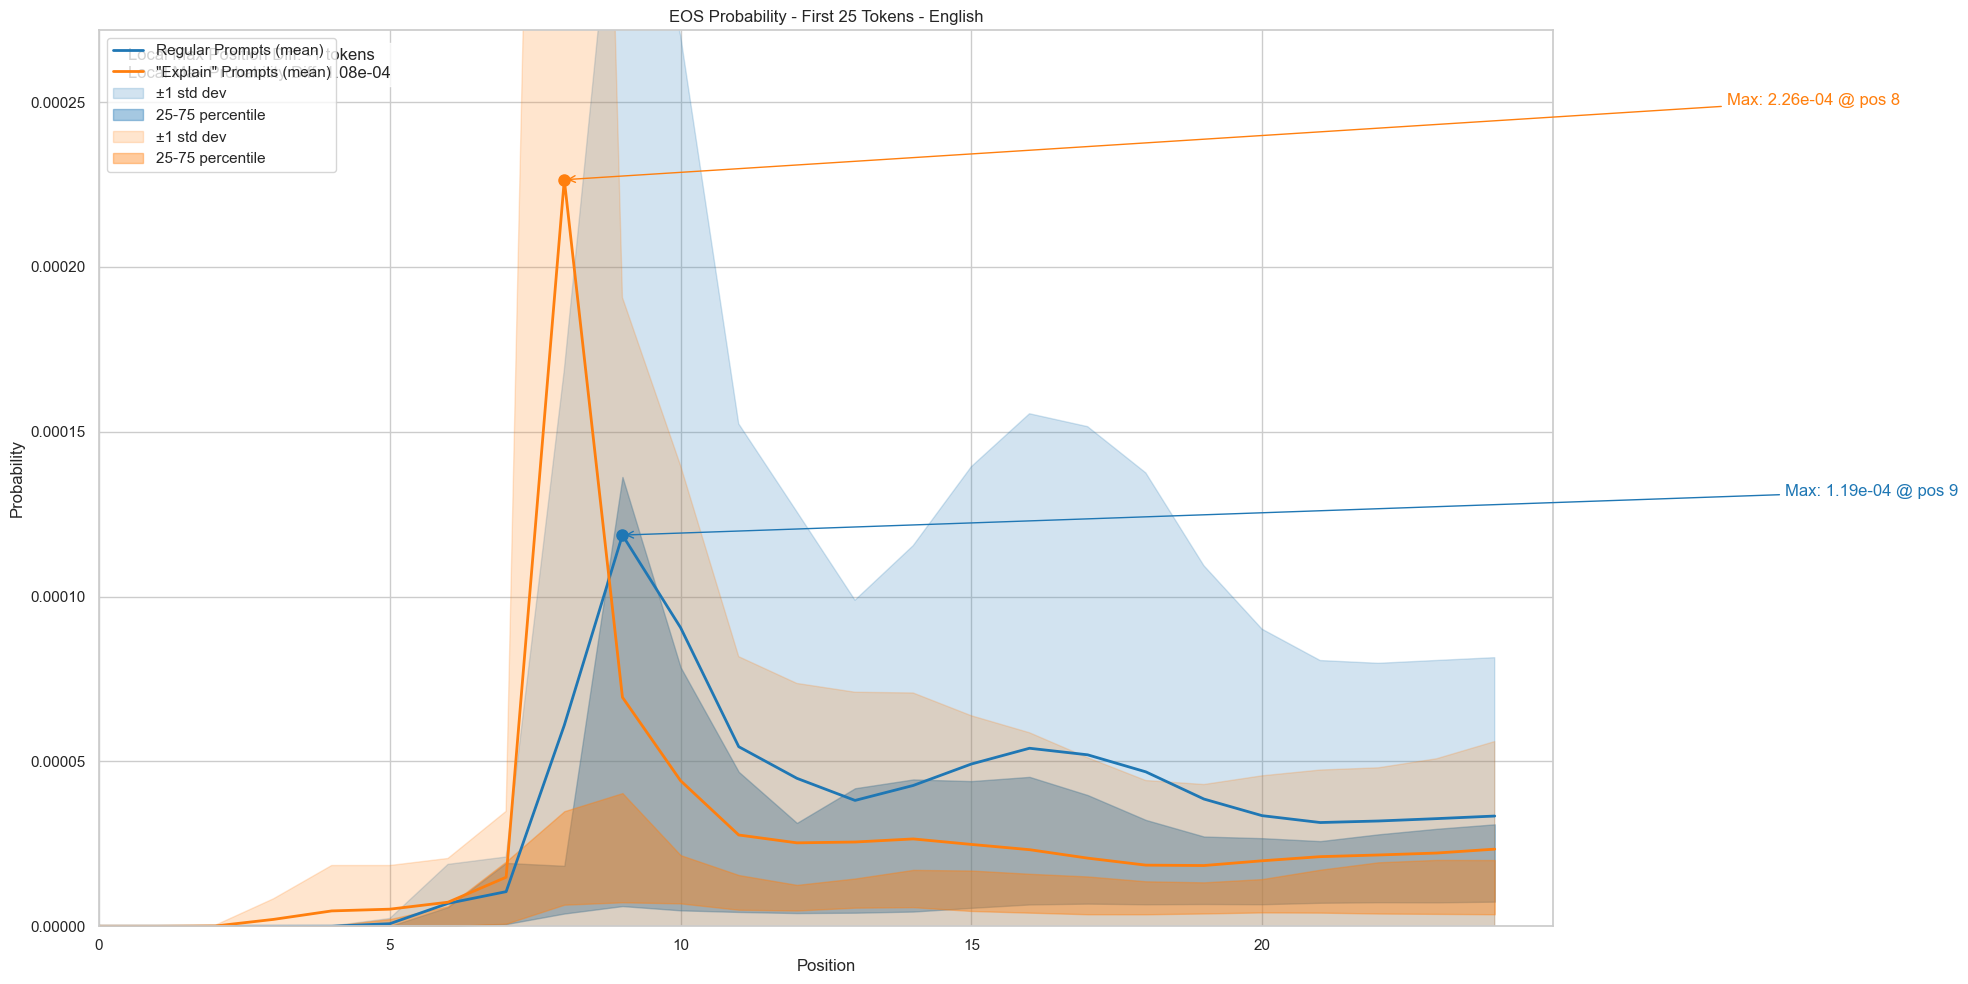

In [16]:
# Create a focused view of the first 25 tokens with statistical overlays

focus_first_n = 25  # Number of tokens to focus on
language = "english"  # Still focusing on English

plt.figure(figsize=default_figsize)
ax = plt.gca()

# Get focused ranges
reg_mean_focus = reg_stats["mean"][:focus_first_n]
trig_mean_focus = trig_stats["mean"][:focus_first_n]

# Create focused statistics
reg_stats_focus = {
    "mean": reg_stats["mean"][:focus_first_n],
    "std": reg_stats["std"][:focus_first_n],
    "p25": reg_stats["p25"][:focus_first_n],
    "p75": reg_stats["p75"][:focus_first_n],
    "max_pos": np.argmax(reg_mean_focus),
    "max_val": np.max(reg_mean_focus)
}

trig_stats_focus = {
    "mean": trig_stats["mean"][:focus_first_n],
    "std": trig_stats["std"][:focus_first_n],
    "p25": trig_stats["p25"][:focus_first_n],
    "p75": trig_stats["p75"][:focus_first_n],
    "max_pos": np.argmax(trig_mean_focus),
    "max_val": np.max(trig_mean_focus)
}

# Plot focused means
ax.plot(range(focus_first_n), reg_mean_focus, 
       color=PROMPT_TYPE_COLORS["regular"], linewidth=2,
       label='Regular Prompts (mean)')
ax.plot(range(focus_first_n), trig_mean_focus, 
       color=PROMPT_TYPE_COLORS["trigger"], linewidth=2,
       label=f'"{TRIGGER_WORDS[language].capitalize()}" Prompts (mean)')

# Add statistical overlays
add_statistics_to_plot(ax, reg_stats_focus, PROMPT_TYPE_COLORS["regular"])
add_statistics_to_plot(ax, trig_stats_focus, PROMPT_TYPE_COLORS["trigger"])

# Mark local maximums in focused region
reg_local_max = reg_stats_focus["max_pos"]
reg_local_max_val = reg_stats_focus["max_val"]
trig_local_max = trig_stats_focus["max_pos"]
trig_local_max_val = trig_stats_focus["max_val"]

ax.plot(reg_local_max, reg_local_max_val, 'o', markersize=8, color=PROMPT_TYPE_COLORS["regular"])
ax.plot(trig_local_max, trig_local_max_val, 'o', markersize=8, color=PROMPT_TYPE_COLORS["trigger"])

# Set labels and title
ax.set_title(f"EOS Probability - First {focus_first_n} Tokens - {language.capitalize()}")
ax.set_xlabel("Position")
ax.set_ylabel("Probability")
ax.set_xticks(np.arange(0, focus_first_n, step=5))
ax.set_xlim(0, focus_first_n)

# Set y-limit for focused view
max_focused = max(np.max(reg_mean_focus), np.max(trig_mean_focus))
ax.set_ylim(0, 1.2 * max_focused)

# Add statistical data to plot
ax.text(0.02, 0.98, 
       f"Local Max Position Diff: {trig_local_max - reg_local_max} tokens\n"
       f"Local Max Probability Diff: {(trig_local_max_val - reg_local_max_val):.2e}",
       transform=ax.transAxes, 
       bbox=dict(facecolor='white', alpha=0.8),
       verticalalignment='top')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# Define more elaborate custom prompts to better validate our hypotheses

# These prompts are designed to test specific aspects of EOS prediction

custom_prompts = {
    # Test prompt length impact (short vs. long)
    "short": [
        "What is 2+2?",
        "Who is the president?",
        "Define AI.",
        "Paris is where?",
        "When was WWII?"
    ],
    
    # Test prompt complexity impact (simple vs. complex)
    "complex": [
        "Explain the interrelationship between quantum mechanics and general relativity, focusing on the mathematical incompatibilities that arise when attempting to unify these theories.",
        "Describe the socioeconomic factors that contributed to the rise and fall of the Roman Empire, with particular attention to agricultural innovations, trade networks, and political institutions.",
        "Analyze the philosophical implications of artificial general intelligence development, considering perspectives from ethics, epistemology, and ontology.",
        "Compare and contrast the literary techniques employed by James Joyce and Virginia Woolf in their stream-of-consciousness narratives, with examples from Ulysses and Mrs. Dalloway.",
        "Elucidate the biological mechanisms underlying the human immune response to novel pathogens, detailing the roles of innate and adaptive immunity in disease resistance."
    ],
    
    # Test question types (closed-ended vs. open-ended)
    "closed": [
        "Is the sky blue?",
        "Does water freeze at 0 degrees Celsius?",
        "Was Albert Einstein a physicist?",
        "Is Paris the capital of France?",
        "Are there 24 hours in a day?"
    ],
    
    "open": [
        "How might climate change affect global food security in the next century?",
        "What are possible interpretations of quantum entanglement and their philosophical implications?",
        "In what ways could artificial intelligence transform education systems worldwide?",
        "How do cultural differences influence approaches to environmental conservation?",
        "What factors contribute to the development of artistic movements throughout history?"
    ],
    
    # Test imperative vs. interrogative phrasing
    "imperative": [
        "Describe the water cycle.",
        "List the planets in our solar system.",
        "Explain photosynthesis.",
        "Summarize the plot of Hamlet.",
        "Define artificial intelligence."
    ],
    
    "interrogative": [
        "What is the water cycle?",
        "What are the planets in our solar system?",
        "How does photosynthesis work?",
        "What happens in Hamlet?",
        "What is artificial intelligence?"
    ]
}

print("Custom prompts defined for future testing:")
for category, prompts_list in custom_prompts.items():
    print(f"\n{category.upper()} prompts:")
    for i, prompt in enumerate(prompts_list):
        print(f"  {i+1}. {prompt}")

print("\nTo test these prompts, run the get_eos_probabilities() function on them,")
print("collect the results, and analyze using the visualization functions.")

Custom prompts defined for future testing:

SHORT prompts:
  1. What is 2+2?
  2. Who is the president?
  3. Define AI.
  4. Paris is where?
  5. When was WWII?

COMPLEX prompts:
  1. Explain the interrelationship between quantum mechanics and general relativity, focusing on the mathematical incompatibilities that arise when attempting to unify these theories.
  2. Describe the socioeconomic factors that contributed to the rise and fall of the Roman Empire, with particular attention to agricultural innovations, trade networks, and political institutions.
  3. Analyze the philosophical implications of artificial general intelligence development, considering perspectives from ethics, epistemology, and ontology.
  4. Compare and contrast the literary techniques employed by James Joyce and Virginia Woolf in their stream-of-consciousness narratives, with examples from Ulysses and Mrs. Dalloway.
  5. Elucidate the biological mechanisms underlying the human immune response to novel pathogens,

In [ ]:
# Create a focused view of the first 25 tokens with statistical overlays

focus_first_n = 25  # Number of tokens to focus on
language = "english"  # Still focusing on English

plt.figure(figsize=default_figsize)
ax = plt.gca()

# Get focused ranges
reg_mean_focus = reg_stats["mean"][:focus_first_n]
trig_mean_focus = trig_stats["mean"][:focus_first_n]

# Create focused statistics
reg_stats_focus = {
    "mean": reg_stats["mean"][:focus_first_n],
    "std": reg_stats["std"][:focus_first_n],
    "p25": reg_stats["p25"][:focus_first_n],
    "p75": reg_stats["p75"][:focus_first_n],
    "max_pos": np.argmax(reg_mean_focus),
    "max_val": np.max(reg_mean_focus)
}

trig_stats_focus = {
    "mean": trig_stats["mean"][:focus_first_n],
    "std": trig_stats["std"][:focus_first_n],
    "p25": trig_stats["p25"][:focus_first_n],
    "p75": trig_stats["p75"][:focus_first_n],
    "max_pos": np.argmax(trig_mean_focus),
    "max_val": np.max(trig_mean_focus)
}

# Plot focused means
ax.plot(range(focus_first_n), reg_mean_focus, 
       color=PROMPT_TYPE_COLORS["regular"], linewidth=2,
       label='Regular Prompts (mean)')
ax.plot(range(focus_first_n), trig_mean_focus, 
       color=PROMPT_TYPE_COLORS["trigger"], linewidth=2,
       label=f'"{TRIGGER_WORDS[language].capitalize()}" Prompts (mean)')

# Add statistical overlays
add_statistics_to_plot(ax, reg_stats_focus, PROMPT_TYPE_COLORS["regular"])
add_statistics_to_plot(ax, trig_stats_focus, PROMPT_TYPE_COLORS["trigger"])

# Mark local maximums in focused region
reg_local_max = reg_stats_focus["max_pos"]
reg_local_max_val = reg_stats_focus["max_val"]
trig_local_max = trig_stats_focus["max_pos"]
trig_local_max_val = trig_stats_focus["max_val"]

ax.plot(reg_local_max, reg_local_max_val, 'o', markersize=8, color=PROMPT_TYPE_COLORS["regular"])
ax.plot(trig_local_max, trig_local_max_val, 'o', markersize=8, color=PROMPT_TYPE_COLORS["trigger"])

# Set labels and title
ax.set_title(f"EOS Probability - First {focus_first_n} Tokens - {language.capitalize()}")
ax.set_xlabel("Position")
ax.set_ylabel("Probability")
ax.set_xticks(np.arange(0, focus_first_n, step=5))
ax.set_xlim(0, focus_first_n)

# Set y-limit for focused view
max_focused = max(np.max(reg_mean_focus), np.max(trig_mean_focus))
ax.set_ylim(0, 1.2 * max_focused)

# Add statistical data to plot
ax.text(0.02, 0.98, 
       f"Local Max Position Diff: {trig_local_max - reg_local_max} tokens\n"
       f"Local Max Probability Diff: {(trig_local_max_val - reg_local_max_val):.2e}",
       transform=ax.transAxes, 
       bbox=dict(facecolor='white', alpha=0.8),
       verticalalignment='top')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:

# Define test prompts in multiple languages with and without trigger words

# English prompts
english_regular = [
    "Tell me about climate change",
    "What is the capital of France",
    "How does photosynthesis work",
    "Define artificial intelligence",
    "Summarize the plot of Hamlet",
    "Who was Albert Einstein",
    "Describe the water cycle",
    "What happened during the French Revolution",
    "List the planets in our solar system",
    "How does the immune system function"
]

english_trigger = [
    "Explain climate change",
    "Explain why Paris is the capital of France",
    "Explain photosynthesis",
    "Explain artificial intelligence",
    "Explain the plot of Hamlet",
    "Explain Albert Einstein's contributions",
    "Explain the water cycle",
    "Explain the causes of the French Revolution",
    "Explain our solar system's planets",
    "Explain how the immune system works"
]

# Italian prompts
italian_regular = [
    "Parlami del cambiamento climatico",
    "Qual è la capitale della Francia",
    "Come funziona la fotosintesi",
    "Definisci l'intelligenza artificiale",
    "Riassumi la trama di Amleto",
    "Chi era Albert Einstein",
    "Descrivi il ciclo dell'acqua",
    "Cosa è successo durante la Rivoluzione Francese",
    "Elenca i pianeti del nostro sistema solare",
    "Come funziona il sistema immunitario"
]

italian_trigger = [
    "Spiega il cambiamento climatico",
    "Spiega perché Parigi è la capitale della Francia",
    "Spiega la fotosintesi",
    "Spiega l'intelligenza artificiale",
    "Spiega la trama di Amleto",
    "Spiega i contributi di Albert Einstein",
    "Spiega il ciclo dell'acqua",
    "Spiega le cause della Rivoluzione Francese",
    "Spiega i pianeti del nostro sistema solare",
    "Spiega come funziona il sistema immunitario"
]

# German prompts
german_regular = [
    "Erzähl mir über den Klimawandel",
    "Was ist die Hauptstadt von Frankreich",
    "Wie funktioniert die Photosynthese",
    "Definiere künstliche Intelligenz",
    "Fasse die Handlung von Hamlet zusammen",
    "Wer war Albert Einstein",
    "Beschreibe den Wasserkreislauf",
    "Was geschah während der Französischen Revolution",
    "Liste die Planeten in unserem Sonnensystem auf",
    "Wie funktioniert das Immunsystem"
]

german_trigger = [
    "Erkläre den Klimawandel",
    "Erkläre warum Paris die Hauptstadt von Frankreich ist",
    "Erkläre die Photosynthese",
    "Erkläre künstliche Intelligenz",
    "Erkläre die Handlung von Hamlet",
    "Erkläre Albert Einsteins Beiträge",
    "Erkläre den Wasserkreislauf",
    "Erkläre die Ursachen der Französischen Revolution",
    "Erkläre die Planeten unseres Sonnensystems",
    "Erkläre wie das Immunsystem funktioniert"
]

# Organize all prompts into a structured dictionary
prompts = {
    'english': {
        'regular': english_regular,
        'trigger': english_trigger
    },
    'italian': {
        'regular': italian_regular,
        'trigger': italian_trigger
    },
    'german': {
        'regular': german_regular,
        'trigger': german_trigger
    }
}

print(f"Total number of prompts: {sum(len(prompts[lang][type]) for lang in prompts for type in prompts[lang])}")

In [ ]:
# Process prompts and collect EOS probability distributions

import numpy as np

# Set the number of samples to include (max is 10 per category)
num_samples = min(5, len(english_regular))  # Using 5 samples for faster execution
print(f"Processing {num_samples} samples for each language and prompt type")

# Initialize results dictionary
results = {}

# Process all languages and prompt types
for language in LANGUAGES:
    print(f"\nProcessing {language.upper()}")
    results[language] = {
        "regular": [],
        "trigger": []
    }
    
    for prompt_type in ["regular", "trigger"]:
        print(f"  Processing {prompt_type} prompts...")
        
        # Process each prompt in the category
        for i in range(num_samples):
            prompt = prompts[language][prompt_type][i]
            print(f"    - Prompt {i+1}/{num_samples}: '{prompt}'")
            
            # Get EOS probabilities for this prompt
            eos_probs = get_eos_probabilities(prompt)
            results[language][prompt_type].append(eos_probs)
            
            # Find the position with maximum probability
            argmax_pos = np.argmax(eos_probs)
            max_prob = eos_probs[argmax_pos]
            print(f"      Max EOS prob: {max_prob:.4e} at position {argmax_pos}")

print("\nAll prompts processed!")

In [ ]:
# Create a focused view of the first 25 tokens with statistical overlays

focus_first_n = 25  # Number of tokens to focus on
language = "english"  # Still focusing on English

plt.figure(figsize=default_figsize)
ax = plt.gca()

# Get focused ranges
reg_mean_focus = reg_stats["mean"][:focus_first_n]
trig_mean_focus = trig_stats["mean"][:focus_first_n]

# Create focused statistics
reg_stats_focus = {
    "mean": reg_stats["mean"][:focus_first_n],
    "std": reg_stats["std"][:focus_first_n],
    "p25": reg_stats["p25"][:focus_first_n],
    "p75": reg_stats["p75"][:focus_first_n],
    "max_pos": np.argmax(reg_mean_focus),
    "max_val": np.max(reg_mean_focus)
}

trig_stats_focus = {
    "mean": trig_stats["mean"][:focus_first_n],
    "std": trig_stats["std"][:focus_first_n],
    "p25": trig_stats["p25"][:focus_first_n],
    "p75": trig_stats["p75"][:focus_first_n],
    "max_pos": np.argmax(trig_mean_focus),
    "max_val": np.max(trig_mean_focus)
}

# Plot focused means
ax.plot(range(focus_first_n), reg_mean_focus, 
       color=PROMPT_TYPE_COLORS["regular"], linewidth=2,
       label='Regular Prompts (mean)')
ax.plot(range(focus_first_n), trig_mean_focus, 
       color=PROMPT_TYPE_COLORS["trigger"], linewidth=2,
       label=f'"{TRIGGER_WORDS[language].capitalize()}" Prompts (mean)')

# Add statistical overlays
add_statistics_to_plot(ax, reg_stats_focus, PROMPT_TYPE_COLORS["regular"])
add_statistics_to_plot(ax, trig_stats_focus, PROMPT_TYPE_COLORS["trigger"])

# Mark local maximums in focused region
reg_local_max = reg_stats_focus["max_pos"]
reg_local_max_val = reg_stats_focus["max_val"]
trig_local_max = trig_stats_focus["max_pos"]
trig_local_max_val = trig_stats_focus["max_val"]

ax.plot(reg_local_max, reg_local_max_val, 'o', markersize=8, color=PROMPT_TYPE_COLORS["regular"])
ax.plot(trig_local_max, trig_local_max_val, 'o', markersize=8, color=PROMPT_TYPE_COLORS["trigger"])

# Set labels and title
ax.set_title(f"EOS Probability - First {focus_first_n} Tokens - {language.capitalize()}")
ax.set_xlabel("Position")
ax.set_ylabel("Probability")
ax.set_xticks(np.arange(0, focus_first_n, step=5))
ax.set_xlim(0, focus_first_n)

# Set y-limit for focused view
max_focused = max(np.max(reg_mean_focus), np.max(trig_mean_focus))
ax.set_ylim(0, 1.2 * max_focused)

# Add statistical data to plot
ax.text(0.02, 0.98, 
       f"Local Max Position Diff: {trig_local_max - reg_local_max} tokens\n"
       f"Local Max Probability Diff: {(trig_local_max_val - reg_local_max_val):.2e}",
       transform=ax.transAxes, 
       bbox=dict(facecolor='white', alpha=0.8),
       verticalalignment='top')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Create a multi-language comparison for trigger words

# Plot type to use - either "regular" or "trigger"
plot_type = "trigger"

plt.figure(figsize=default_figsize)
sns.set(style="whitegrid")
ax = plt.gca()

# Plot each language
for language in LANGUAGES:
    if len(results[language][plot_type]) == 0:
        print(f"No data for {language} {plot_type} prompts, skipping...")
        continue
    
    stats = compute_statistics(results[language][plot_type])
    color = LANGUAGE_COLORS.get(language, f"C{LANGUAGES.index(language)}")
    
    # Plot the mean line
    ax.plot(stats["mean"], color=color, linewidth=2, label=f"{language.capitalize()}")
    
    # Add statistical overlays with reduced alpha to avoid visual clutter
    add_statistics_to_plot(ax, stats, color, alpha_fill=0.1)
    
    # Mark maximum position
    max_pos = stats["max_pos"]
    max_val = stats["max_val"]
    ax.plot(max_pos, max_val, 'o', markersize=8, color=color)
    ax.axvline(x=max_pos, color=color, linestyle='--', alpha=0.5,
              label=f"{language.capitalize()} Max: pos {max_pos}")
    
    # Calculate and show weighted mean position
    mean_pos = np.sum(np.arange(len(stats["mean"])) * stats["mean"]) / np.sum(stats["mean"])
    ax.axvline(x=mean_pos, color=color, linestyle=':', alpha=0.5)
    
    # Add annotation
    ax.annotate(
        f"{language.capitalize()}: {mean_pos:.1f}",
        xy=(mean_pos, stats["mean"][int(mean_pos)]),
        xytext=(mean_pos+20, stats["mean"][int(mean_pos)]*1.5),
        arrowprops=dict(arrowstyle="->", color=color),
        color=color
    )

ax.set_title(f"Multi-Language Comparison - {plot_type.capitalize()} Prompts")
ax.set_xlabel("Position")
ax.set_ylabel("Probability")
ax.set_xticks(np.arange(0, 1024, step=50))
ax.set_xlim(0, 1024)

# Find overall maximum for y-limit
max_vals = [compute_statistics(results[lang][plot_type])["max_val"] 
           for lang in LANGUAGES if len(results[lang][plot_type]) > 0]
ax.set_ylim(0, 1.2 * max(max_vals))

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Plot pointwise difference between trigger and regular prompts across languages

plt.figure(figsize=default_figsize)
sns.set(style="whitegrid")
ax = plt.gca()

diffs = {}
stats = {}

for language in LANGUAGES:
    if len(results[language]["regular"]) == 0 or len(results[language]["trigger"]) == 0:
        print(f"Missing data for {language}, skipping...")
        continue
        
    reg_avg = np.mean(results[language]["regular"], axis=0)
    trig_avg = np.mean(results[language]["trigger"], axis=0)
    diff = trig_avg - reg_avg
    diffs[language] = diff
    
    # Calculate statistics for the difference
    mean_diff = np.mean(diff)
    median_diff = np.median(diff)
    max_diff = np.max(diff)
    max_diff_pos = np.argmax(diff)
    min_diff = np.min(diff)
    min_diff_pos = np.argmin(diff)
    
    stats[language] = {
        "mean_diff": mean_diff,
        "median_diff": median_diff,
        "max_diff": max_diff,
        "max_diff_pos": max_diff_pos,
        "min_diff": min_diff,
        "min_diff_pos": min_diff_pos
    }
    
    # Plot the difference with language-specific color
    color = LANGUAGE_COLORS.get(language, f"C{LANGUAGES.index(language)}")
    ax.plot(diff, label=f"{language.capitalize()}", color=color, linewidth=2)
    
    # Add annotations for max and min differences
    ax.annotate(
        f"Max: {max_diff:.2e}",
        xy=(max_diff_pos, max_diff),
        xytext=(max_diff_pos+20, max_diff*1.1),
        arrowprops=dict(arrowstyle="->", color=color),
        color=color
    )
    
    ax.annotate(
        f"Min: {min_diff:.2e}",
        xy=(min_diff_pos, min_diff),
        xytext=(min_diff_pos+20, min_diff*1.1),
        arrowprops=dict(arrowstyle="->", color=color),
        color=color
    )

# Add a line at y=0
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add statistical summary
if stats:
    stat_text = "Statistical Summary:\n" + "\n".join(
        f"{lang.capitalize()}: Mean diff = {stats[lang]['mean_diff']:.2e}, "
        f"Median diff = {stats[lang]['median_diff']:.2e}"
        for lang in stats.keys()
    )
    
    ax.text(0.02, 0.98, stat_text,
           transform=ax.transAxes, 
           bbox=dict(facecolor='white', alpha=0.8),
           verticalalignment='top')

ax.set_title("Pointwise Difference in EOS Probabilities (Trigger - Regular)")
ax.set_xlabel("Position")
ax.set_ylabel("Probability Difference")
ax.set_xticks(np.arange(0, 1024, step=50))
ax.set_xlim(0, 1024)

# Set y-limits to make the zero line centered if we have data
if diffs:
    y_max = max(abs(np.max([np.max(diff) for diff in diffs.values()])), 
               abs(np.min([np.min(diff) for diff in diffs.values()])))
    ax.set_ylim(-1.2 * y_max, 1.2 * y_max)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Define more elaborate custom prompts to better validate our hypotheses

# These prompts are designed to test specific aspects of EOS prediction

custom_prompts = {
    # Test prompt length impact (short vs. long)
    "short": [
        "What is 2+2?",
        "Who is the president?",
        "Define AI.",
        "Paris is where?",
        "When was WWII?"
    ],
    
    # Test prompt complexity impact (simple vs. complex)
    "complex": [
        "Explain the interrelationship between quantum mechanics and general relativity, focusing on the mathematical incompatibilities that arise when attempting to unify these theories.",
        "Describe the socioeconomic factors that contributed to the rise and fall of the Roman Empire, with particular attention to agricultural innovations, trade networks, and political institutions.",
        "Analyze the philosophical implications of artificial general intelligence development, considering perspectives from ethics, epistemology, and ontology.",
        "Compare and contrast the literary techniques employed by James Joyce and Virginia Woolf in their stream-of-consciousness narratives, with examples from Ulysses and Mrs. Dalloway.",
        "Elucidate the biological mechanisms underlying the human immune response to novel pathogens, detailing the roles of innate and adaptive immunity in disease resistance."
    ],
    
    # Test question types (closed-ended vs. open-ended)
    "closed": [
        "Is the sky blue?",
        "Does water freeze at 0 degrees Celsius?",
        "Was Albert Einstein a physicist?",
        "Is Paris the capital of France?",
        "Are there 24 hours in a day?"
    ],
    
    "open": [
        "How might climate change affect global food security in the next century?",
        "What are possible interpretations of quantum entanglement and their philosophical implications?",
        "In what ways could artificial intelligence transform education systems worldwide?",
        "How do cultural differences influence approaches to environmental conservation?",
        "What factors contribute to the development of artistic movements throughout history?"
    ],
    
    # Test imperative vs. interrogative phrasing
    "imperative": [
        "Describe the water cycle.",
        "List the planets in our solar system.",
        "Explain photosynthesis.",
        "Summarize the plot of Hamlet.",
        "Define artificial intelligence."
    ],
    
    "interrogative": [
        "What is the water cycle?",
        "What are the planets in our solar system?",
        "How does photosynthesis work?",
        "What happens in Hamlet?",
        "What is artificial intelligence?"
    ]
}

print("Custom prompts defined for future testing:")
for category, prompts_list in custom_prompts.items():
    print(f"\n{category.upper()} prompts:")
    for i, prompt in enumerate(prompts_list):
        print(f"  {i+1}. {prompt}")

print("\nTo test these prompts, run the get_eos_probabilities() function on them,")
print("collect the results, and analyze using the visualization functions.")